# Install libreries 

In [1]:
%pip install gensim nltk pandas seaborn keras
%pip install -U scikit-learn
%pip install tensorflow
%pip install gensim scikit-learn
%pip install torch transformers scikit-learn
%pip install transformers --upgrade


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('floresta')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
from nltk import pos_tag, word_tokenize
import pandas as pd
import numpy as np


import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package floresta to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Get Datasets from Gitbub

In [3]:
import pandas as pd

def read_and_convert_labels(file_url):
    # Read the file into a pandas DataFrame
    df = pd.read_csv(file_url, sep="\t")

    # Map labels to numerical values
    label_mapping = {'NO': 0, 'NOE': 1, 'OFG': 2, 'OFP': 3}
    df['label_num'] = df['label'].map(label_mapping)

    return df

# Train dataset
train_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/training_set.tsv"
train_df = read_and_convert_labels(train_url)
print(train_df.head())

# Test dataset
test_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/test_set.tsv"
test_df = read_and_convert_labels(test_url)
print(test_df.head())

# Validation dataset
val_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/dev_set.tsv"
val_df = read_and_convert_labels(val_url)
print(val_df.head())


   comment_id                                            comment   
0       52564  En vez de la magia de mi melena, la magia de m...  \
1       32984  A ver, los milenials y la gente normal necesit...   
2       58447  Me encanta todo el contenido que haces se nota...   
3       10341  a Laura sige así que vales mucho más que 10 o ...   
4       53087  Y si no mes gusta Dalas, que hacen aquí,lárgue...   

       influencer influencer_gender      media label  label_num  
0           dalas               man  instagram    NO          0  
1  soyunapringada             woman    youtube    NO          0  
2       wildhater               man  instagram    NO          0  
3     lauraescane             woman    youtube    NO          0  
4           dalas               man  instagram    NO          0  
   comment_id                                           comment influencer   
0       54745                                   Lacasito moreno   wismichu  \
1        5595                    Yo pen

# Normalize data

In [4]:

def clean_text(text):
  text = ' '.join([ word for word in text.split(' ') if not word.startswith('@') ])
  text = re.sub(r"[^A-Za-z ]+", '', text) # keep only letters and spaces
  text = text.strip()
  return text

def remove_stop_words(text):
  stopwords_pt = stopwords.words('spanish')
  text_without_sw = [word for word in text.split(' ') if not word in stopwords_pt]
  return (" ").join(text_without_sw)

def lemmatization_nltk(text):
  lemmatizer = WordNetLemmatizer()
  words = nltk.word_tokenize(text, language='spanish')
  lemmas = [lemmatizer.lemmatize(p).lower() for p in words]
  return (" ").join(lemmas)


def remove_proper_nouns(text):
    words = []
    for word, tag in pos_tag(word_tokenize(text)):
        if tag != 'NNP' and tag != 'NNPS':  # Check for proper nouns tags
            words.append(word)
    return ' '.join(words)


def remove_urls(text):
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'

    # Remove URLs from the text using the pattern
    text_without_urls = re.sub(url_pattern, '', text)

    return text_without_urls

def normalize_text(text):
  text = remove_urls(text)
  text = clean_text(text)
  text = remove_proper_nouns(text)
  text = text.lower() 
  text = remove_stop_words(text)
  text = lemmatization_nltk(text)

  return text

In [5]:
def normalize_data(df, text_column):
    # Filter DataFrame and remove NaN values
    df_filtered = df[df[text_column].notna()]

    # Normalize text
    df_filtered['comment_clean'] = df_filtered[text_column].apply(normalize_text)

    return df_filtered

train_df = normalize_data(train_df, 'comment')
test_df = normalize_data(test_df, 'comment')
val_df = normalize_data(val_df, 'comment')
def convert_labels(df):
    # Create a new column 'label_num' and initialize with -1
    df['label_num'] = -1

    # Map labels to numerical values
    df.loc[df['label'] == 'NO', 'label_num'] = 0
    df.loc[df['label'] == 'NOE', 'label_num'] = 1
    df.loc[df['label'] == 'OFG', 'label_num'] = 2
    df.loc[df['label'] == 'OFP', 'label_num'] = 3       

    return df
train_df = convert_labels(train_df)
test_df = convert_labels(test_df)
val_df = convert_labels(val_df)

# Balance data for training

212
423
Balanced Train Data size: 30316
Balanced Test Data size: 13606
Balanced val Data size: 100
 Train Data size: 16710
 Test Data size: 13606


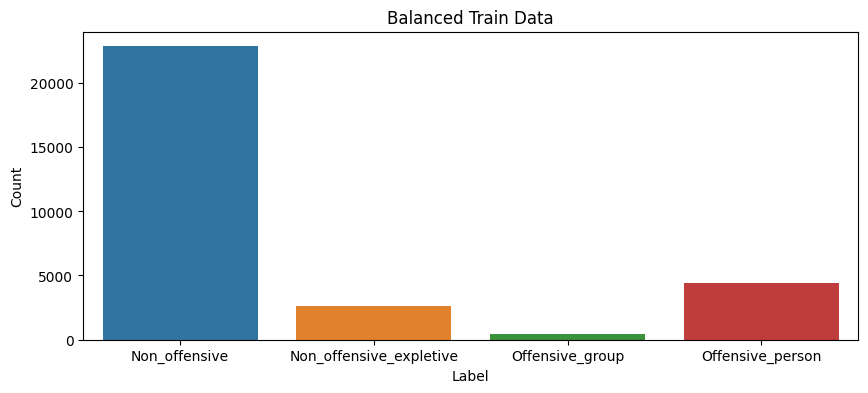

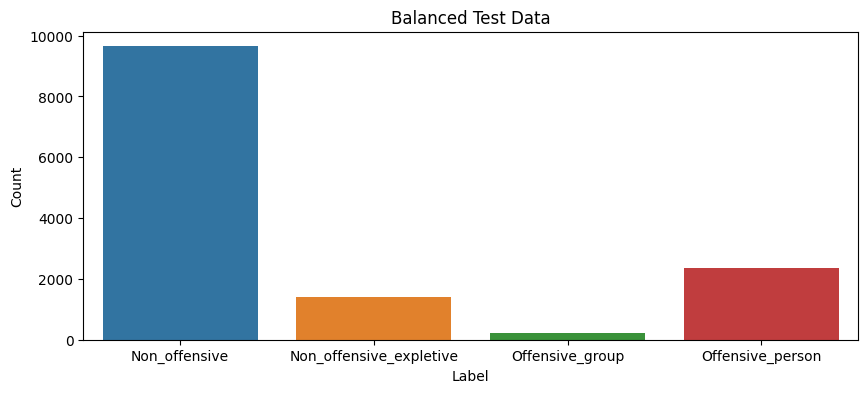

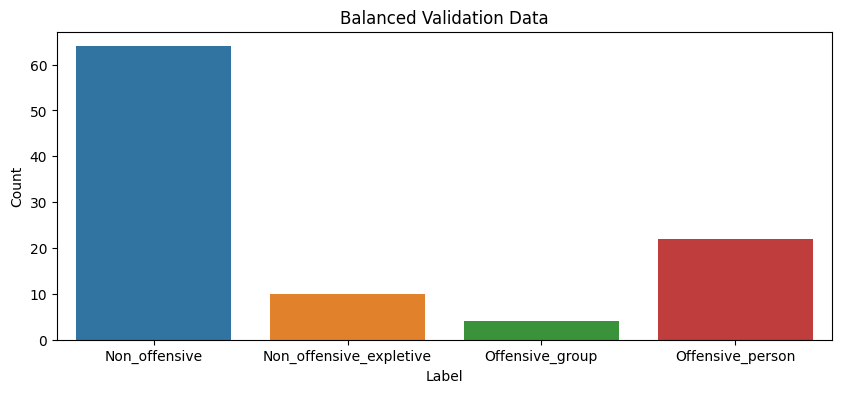

In [6]:

# Get the minimum count among all labels
min_count_train = train_df['label_num'].value_counts().min()
min_count_test = test_df['label_num'].value_counts().min()
print(min_count_train)

# Filter the training data to include an equal number of instances for each label
balanced_train_data = pd.concat([
    train_df[train_df['label_num'] == 0].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 1].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 2].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 3].sample(min_count_train , random_state=16)
])

# Filter the training data to include an equal number of instances for each label
balanced_train_data = pd.concat([
    train_df[train_df['label_num'] == 0],
    train_df[train_df['label_num'] == 1],
    train_df[train_df['label_num'] == 2],
    train_df[train_df['label_num'] == 3]
])

# Filter the test data to include an equal number of instances for each label
balanced_test_data = pd.concat([
    test_df[test_df['label_num'] == 0],
    test_df[test_df['label_num'] == 1],
    test_df[test_df['label_num'] == 2],
    test_df[test_df['label_num'] == 3]
])


# Filter the training data to include an equal number of instances for each label
"""balanced_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(min_count_train +2000, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(min_count_train +2000 , random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 2].sample(min_count_train , random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(min_count_train +2000 , random_state=16)
])"""
balanced_train_data =  pd.concat([balanced_train_data, balanced_test_data])
min_count_train = balanced_train_data['label_num'].value_counts().min()
print(min_count_train)
# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=16).reset_index(drop=True)
balanced_test_data = balanced_test_data.sample(frac=1, random_state=16).reset_index(drop=True)

# Print the sizes of the balanced datasets
print("Balanced Train Data size:", len(balanced_train_data))
print("Balanced Test Data size:", len(balanced_test_data))
print("Balanced val Data size:", len(val_df))
# Print the sizes of the balanced datasets
print(" Train Data size:", len(train_df))
print(" Test Data size:", len(test_df))

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_train_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Train Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_test_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Test Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=val_df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Validation Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

Balanced Train Data size: 3100


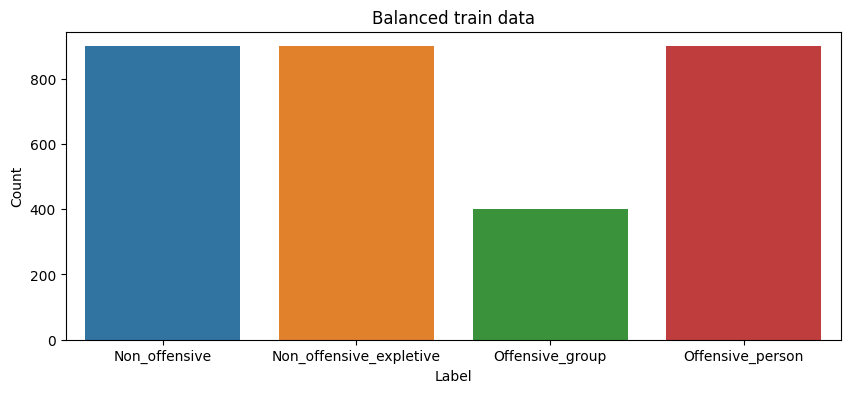

In [7]:
# Get the minimum count among all labels
min_count_train = 400  # Set the desired minimum count for each label

# Filter the training data to include a minimum number of instances for each label
filtered_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 2].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(min_count_train, random_state=16)
])

# Add 500 more instances to specific labels
extra_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(500, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(500, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(500, random_state=16)
])

# Combine the two subsets
balanced_train_data = pd.concat([filtered_train_data, extra_train_data])

# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=16).reset_index(drop=True)

# Print the size of the balanced dataset
print("Balanced Train Data size:", len(balanced_train_data))

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_train_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced train data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()


In [8]:
print("Counts of each label_num:")
print(balanced_train_data['label_num'].value_counts())

Counts of each label_num:
label_num
0    900
3    900
1    900
2    400
Name: count, dtype: int64


# Split the data into training and validation sets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm


In [9]:
from sklearn.utils.class_weight import compute_class_weight

X = balanced_train_data['comment_clean']
y = balanced_train_data['label_num']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weights_dict)

{0: 0.8611111111111112, 1: 0.8611111111111112, 2: 1.9375, 3: 0.8611111111111112}


# bert-base-spanish-wwm-uncased"

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load your data and preprocess it (replace with your data loading code)
X = balanced_train_data['comment_clean']
y = balanced_train_data['label_num']


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Load tokenizer and model
num_labels = len(np.unique(y))  # Number of classes in your task
print(num_labels)
# Load tokenizer and model
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)  # Specify num_labels



# Tokenize and encode the text data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch DataLoader objects
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train.tolist())
)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(y_val.tolist())
)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset), num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset), num_workers=4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")


4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Average training loss: 1.2036
Epoch 2 - Average training loss: 0.7582
Epoch 3 - Average training loss: 0.4444
Epoch 4 - Average training loss: 0.2637
Epoch 5 - Average training loss: 0.1577


In [11]:
import os

# Ensure the output directory exists
output_dir = "bert_spanish_5"
os.makedirs(output_dir, exist_ok=True)

# Save the trained model's state dictionary
model_save_path = os.path.join(output_dir, "model.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Trained model saved at {model_save_path}")

Trained model saved at bert_spanish_5\model.pth


In [15]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Set the model to evaluation mode
model.eval()

# Initialize variables for evaluation
val_loss = 0.0
true_labels = []
predicted_labels = []
class_names = ['Label 0', 'Label 1', 'Label 2', 'Label 3']


# Disable gradient calculation during evaluation
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Validation"):
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        val_loss += loss.item()

        # Get predicted labels
        logits = outputs.logits
        predicted_batch_labels = logits.argmax(dim=1).tolist()
        predicted_labels.extend(predicted_batch_labels)
        true_labels.extend(labels.tolist())

print("Unique true labels:", set(true_labels))
print("Unique predicted labels:", set(predicted_labels))

avg_val_loss = val_loss / len(val_dataloader)
print(f"Average validation loss: {avg_val_loss:.4f}")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])
print("Confusion Matrix:\n", conf_matrix)



Validation: 100%|██████████| 59/59 [03:07<00:00,  3.18s/it]

Unique true labels: {0, 1, 2, 3}
Unique predicted labels: {0, 1, 2, 3}
Average validation loss: 0.5223
Accuracy: 0.8441
Precision: 0.8446
Recall: 0.8441
F1 Score: 0.8426
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.89      0.90      0.90       270
     Label 1       0.83      0.84      0.84       270
     Label 2       0.84      0.66      0.74       120
     Label 3       0.81      0.87      0.84       270

    accuracy                           0.84       930
   macro avg       0.84      0.82      0.83       930
weighted avg       0.84      0.84      0.84       930

Confusion Matrix:
 [[243   9   6  12]
 [ 11 227   5  27]
 [ 12  13  79  16]
 [  7  23   4 236]]


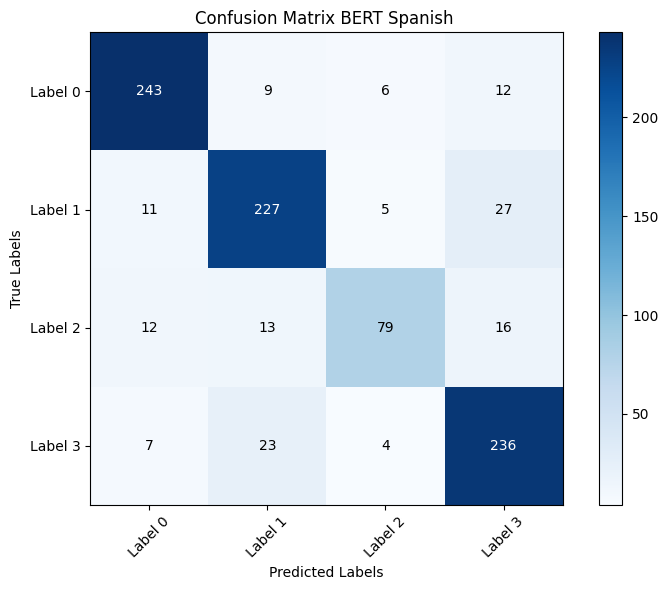

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix BERT Spanish ")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()


# bert-base-multilingual

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load your data and preprocess it (replace with your data loading code)
X = balanced_train_data['comment_clean']
y = balanced_train_data['label_num']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Load tokenizer and model (multilingual)
model_name = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Tokenize and encode the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create PyTorch DataLoader objects
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train.tolist())
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(y_val.tolist())
)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset), num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset), num_workers=4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os

# Ensure the output directory exists
output_dir = "bert_spanish_30A_10"
os.makedirs(output_dir, exist_ok=True)

# Save the trained model's state dictionary
model_save_path = os.path.join(output_dir, "model.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Trained model saved at {model_save_path}")


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for evaluation
val_loss = 0.0
true_labels = []
predicted_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Validation"):
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        val_loss += loss.item()

        # Get predicted labels
        logits = outputs.logits
        predicted_batch_labels = logits.argmax(dim=1).tolist()
        predicted_labels.extend(predicted_batch_labels)
        true_labels.extend(labels.tolist())

print("Unique true labels:", set(true_labels))
print("Unique predicted labels:", set(predicted_labels))

avg_val_loss = val_loss / len(val_dataloader)
print(f"Average validation loss: {avg_val_loss:.4f}")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix BERT multilingual ")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()
